In [37]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.13.0
The following GPU devices are available: 


In [103]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


import tempfile
import io
import os
#from googleapiclient.discovery import build
#from googleapiclient.http import MediaIoBaseDownload
from PIL import Image, ImageOps

def resize_image(image_path, new_width=256, new_height=256, display=False):
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)

    # Save the resized image to a new temporary file
    _, resized_temp_filename = tempfile.mkstemp(suffix=".jpg")
    pil_image.save(resized_temp_filename, format="JPEG", quality=90)

    print("Image resized.")

    # Optionally display the image
    if display:
        pil_image.show()

    # Return the resized temporary file path
    return resized_temp_filename

# Usage example with an image path in Google Colab
image_path = '..\Dataset\JPEGImages\Apple\S_Apple\\apple004S(1).JPG'
resized_image_path = resize_image(image_path, new_width=256, new_height=256, display=True)

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=2, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
      
  return image

Image resized.


In [104]:
downloaded_image_path = resize_image(image_path, 1280, 856, True)

Image resized.


In [40]:
import tensorflow_hub as hub

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [106]:
import tensorflow as tf

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [107]:
import time

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  
  display_image(image_with_boxes)

Found 100 objects.
Inference time:  57.93756461143494
Font not found, using default font.


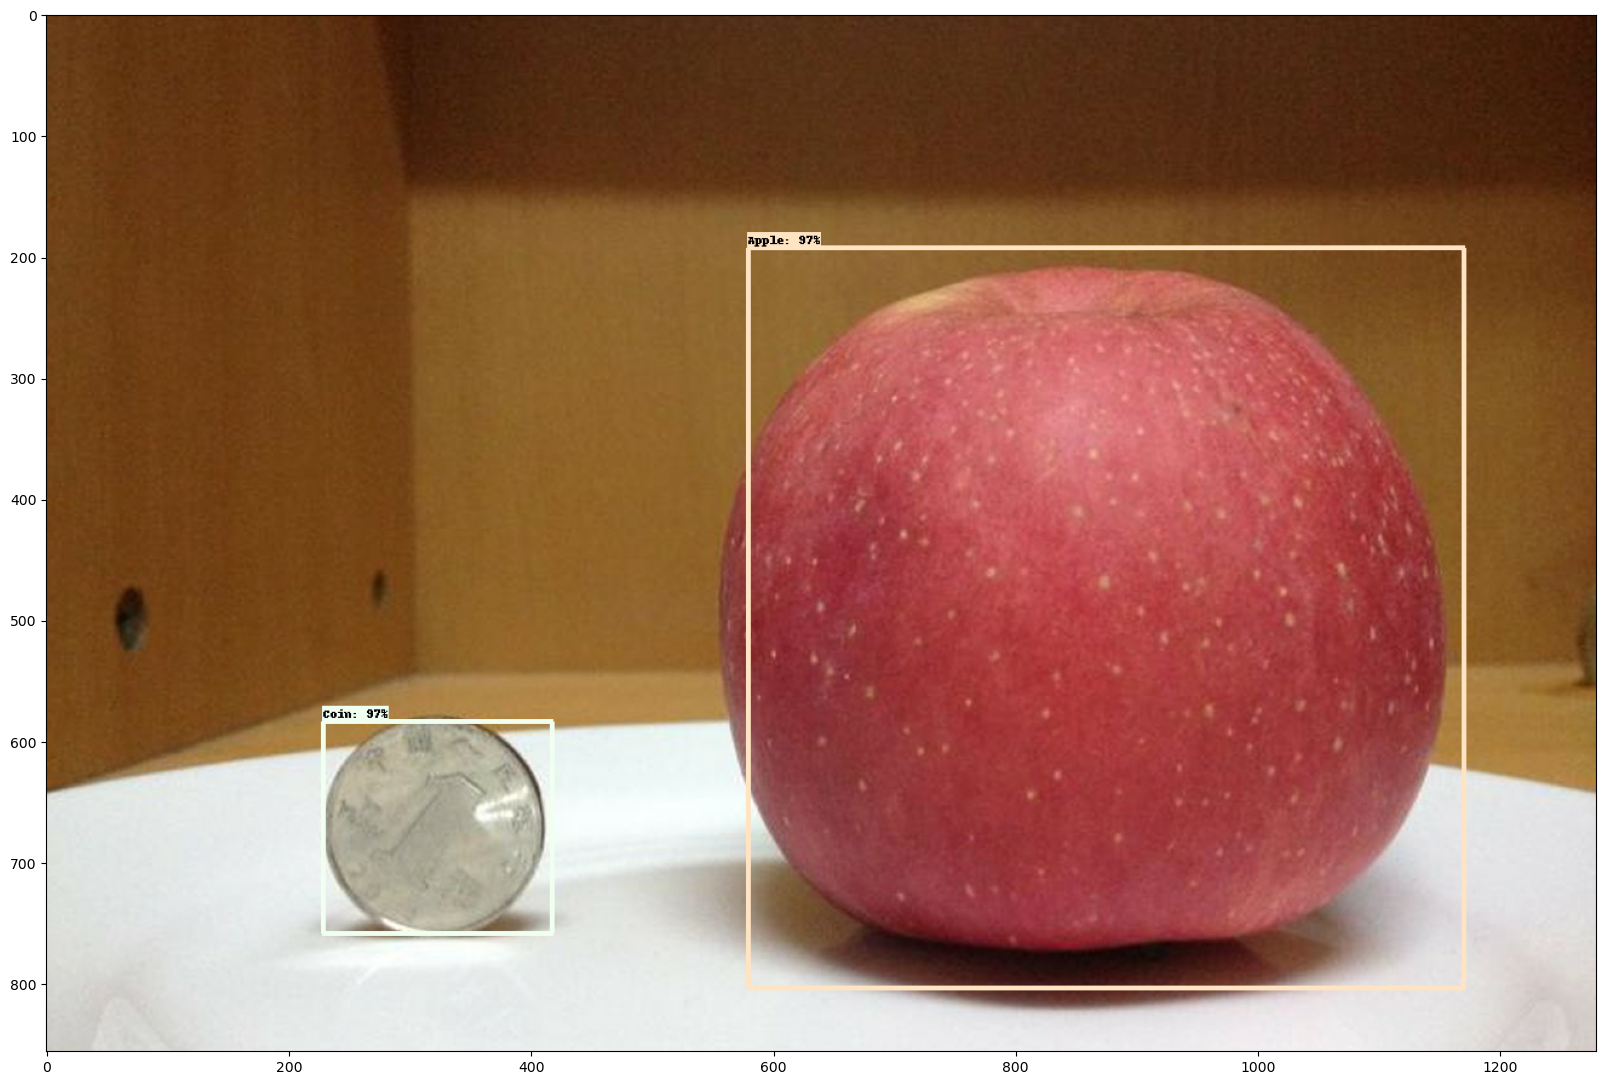

In [108]:
run_detector(detector, downloaded_image_path)

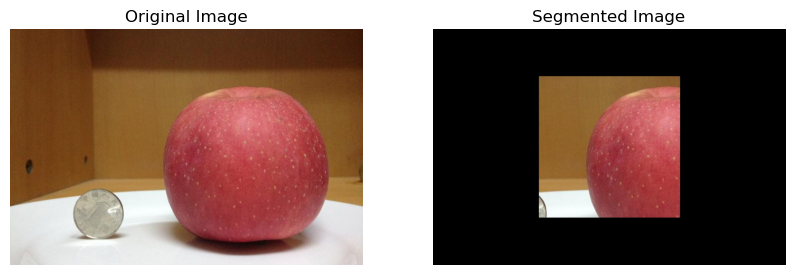

In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def run_grabcut(image_path, bounding_box):
    # Load the image
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Create a mask with zeros, same size as the image
    mask = np.zeros((height, width), np.uint8)

    # Convert the bounding box from normalized coordinates to pixel coordinates
    ymin, xmin, ymax, xmax = bounding_box
    ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

    # Create a binary mask with foreground set to 1 inside the bounding box
    mask[ymin:ymax, xmin:xmax] = 1

    # Initialize the GrabCut algorithm
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Run the GrabCut algorithm with the initial mask
    cv2.grabCut(image, mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

    # Create a binary mask where the foreground is True (3 and 1 are the possible states of the mask)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Multiply the original image with the binary mask to get the segmented image
    segmented_image = image * mask2[:, :, np.newaxis]

    # Display the original image and the segmented image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Segmented Image')

    plt.show()

#image_path = '..\Dataset\JPEGImages\Apple\S_Apple\\apple002S(8).JPG'
# Replace the following bounding_box values with the ones generated by Faster R-CNN
bounding_box = [0.2, 0.3, 0.8, 0.7]

run_grabcut(downloaded_image_path, bounding_box)
